## Overview
Implementation of Shor's Algorithm produced by following the tutorial at\
https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

In [1]:
import numpy as np
from qiskit import *
from qiskit_aer import *
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from fractions import Fraction
from math import gcd

# Period Finding

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]


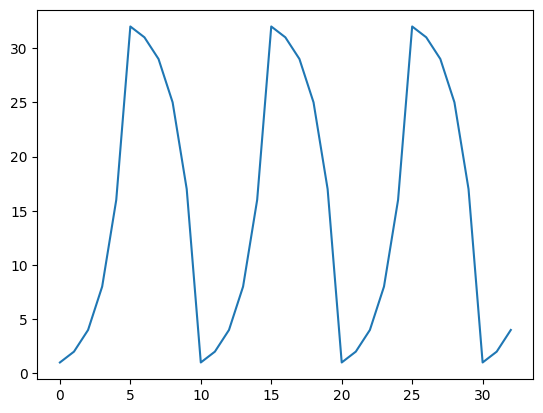

In [55]:
a = 2
mod = 33
x = np.linspace(0,mod - 1, mod)
print(x)
y = (a**x)% mod
plt.plot(x, y)

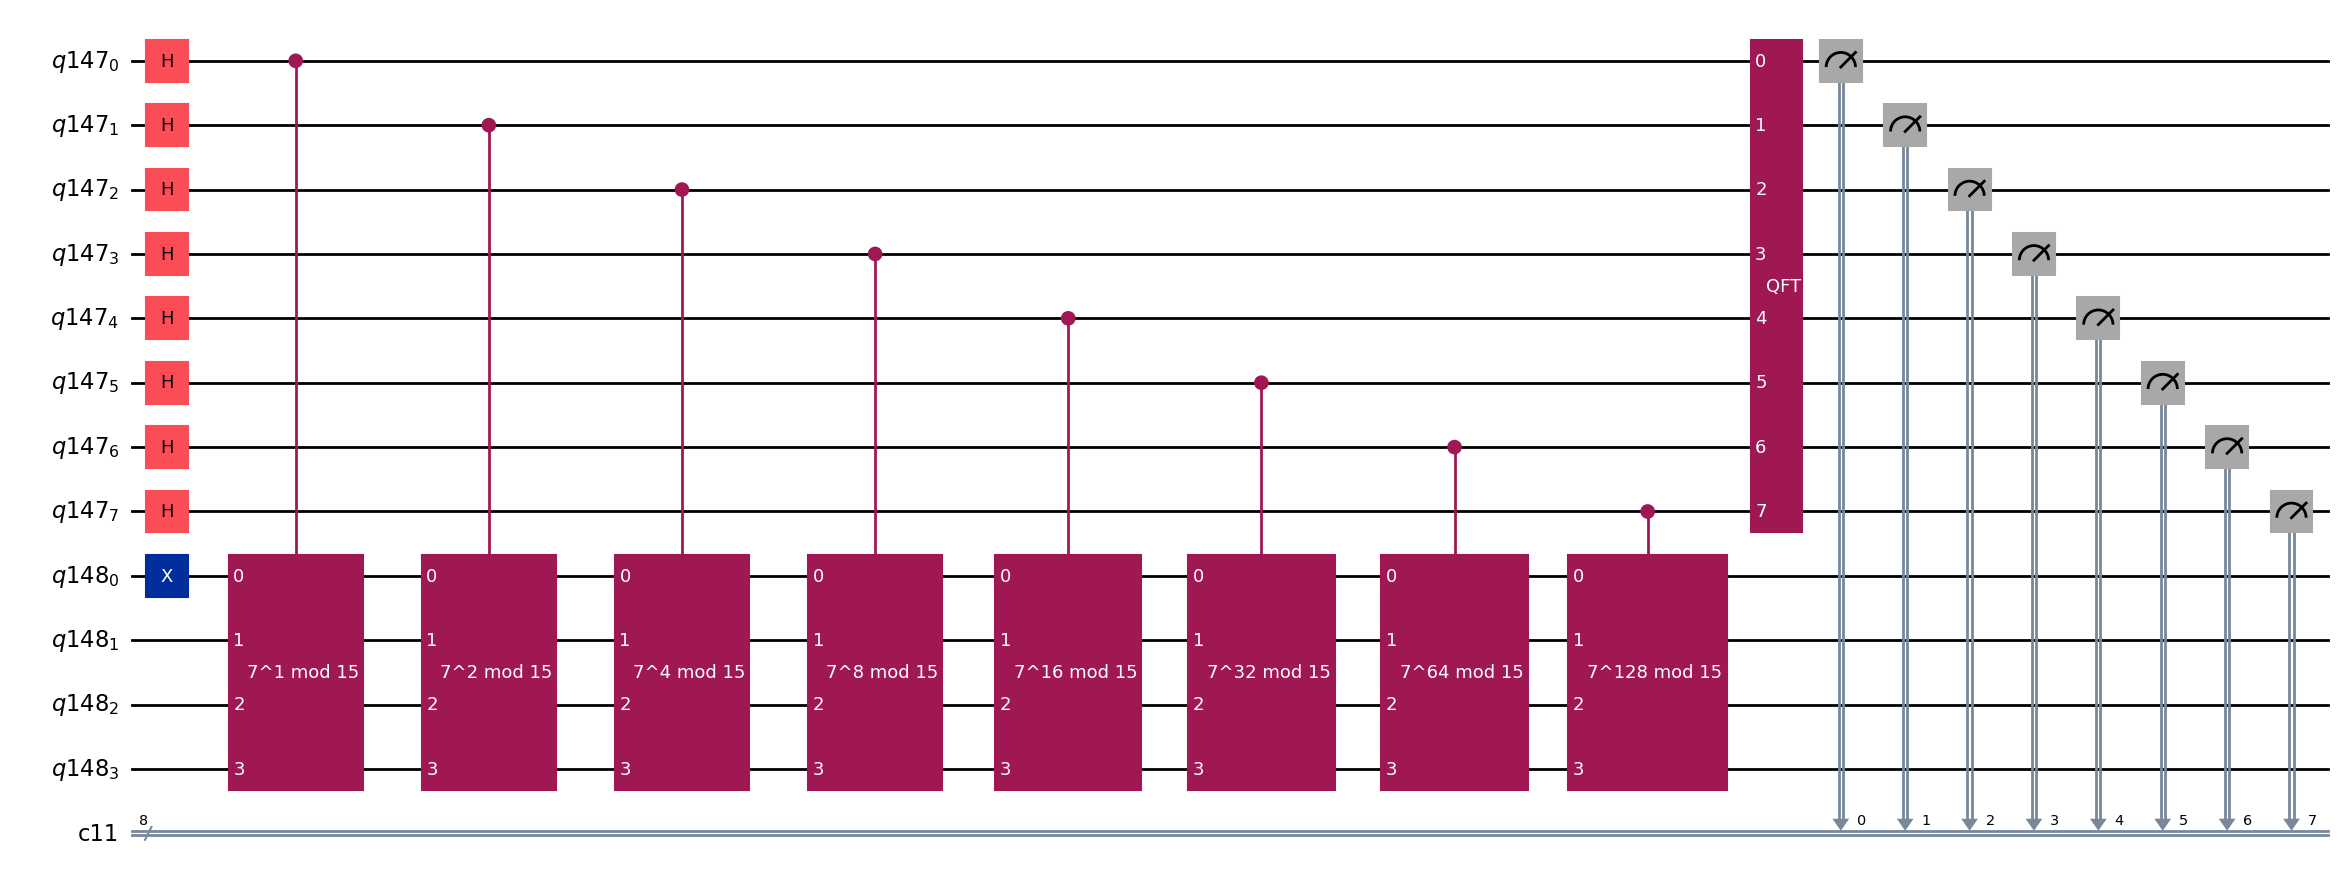

In [33]:
N = 8
W = 4
a = 7
mod = 15

qr1 = QuantumRegister(N)
qr2 = QuantumRegister(W)
c = ClassicalRegister(N)
qft = QFT(num_qubits=N, approximation_degree=0).to_gate()
qc = QuantumCircuit(qr1, qr2, c)
for i in range(N):
    qc.h(i)
qc.x(N)
for q in range(N):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+N for i in range(4)])
qc.append(qft, qargs=range(0,N))
qc.measure(range(0,N), range(0,N))
qc.draw('mpl', fold=-1)

CPU times: total: 609 ms
Wall time: 373 ms


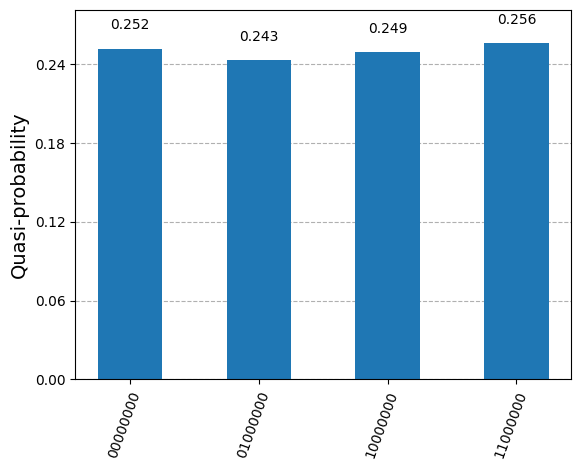

In [34]:
%%time
shots = 5000
simulator = Aer.get_backend("qasm_simulator")
transpiler = transpile(qc, backend=simulator)
result = simulator.run(transpiler, shots=shots).result()
counts = result.get_counts()
for key in counts.keys():
    counts[key] = counts[key]/shots
plot_histogram(counts)

In [35]:
guesses = []
for key in counts.keys(): 
    val = int(key,2)
    dec = val/(2**N)
    guesses.append(Fraction(dec).limit_denominator(15).denominator)
print(guesses)

[1, 4, 4, 2]


# Factoring

In [2]:
## Taken from https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

def c_amod(a, power, mod):
    U = QuantumCircuit(4)
    for _iteration in range(power):
        

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [10]:
N = 15
np.random.seed(1)
a = np.random.randint(2, N)
greatest = gcd(a, N)
if greatest != 1:
    print("Factors Found:")
    print(f"{greatest}, and {N/greatest}")
print(a)

7


In [6]:
def qpe_amod15(a, sim = "Simulate"):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])

    qft = QFT(num_qubits=N_COUNT, approximation_degree=0).to_gate()
    qc.append(qft, qargs=range(0,N_COUNT))
    qc.measure(range(N_COUNT), range(N_COUNT))
    
    if sim == "Simulate:
        # Simulate Results
        aer_sim = Aer.get_backend('aer_simulator')
        # `memory=True` tells the backend to save each measurement in a list
        job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
        readings = job.result().get_memory()
        print("Register Reading: " + readings[0])
        phase = int(readings[0],2)/(2**N_COUNT)
        print(f"Corresponding Phase: {phase}")
    elif sim == "IBMQ:
        phase = 'null'
    return phase

In [7]:
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 01000000
Corresponding Phase: 0.25
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***
